<a href="https://colab.research.google.com/github/PaulToronto/AI-and-Machine-Learning-for-Coders---Book/blob/main/3_2_Building_a_CNN_to_Distinguish_Between_Horses_and_Humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a CNN to Distinguish Between Horses and Humans

## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import os
from google.colab import files

import urllib.request
import zipfile

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

## The Dataset

- In this dataset, the location of a feature is not always in the same place
- Contains over 1000 $300 \times 300$ images, approximately half each of horses and humans, rendered in different poses
- The images have different lighting, different poses, different skin tones, different zoom levels, different backgrounds
    - The classifier will have to determine which parts of the image are important features for the classification, without being affected by the background
- These images are all computer generated

### The Keras ImageDataGenerator

- Many image-based datasets don't have labels, the images are sorted into subdirectories of each type
- In Keras, a tool called `ImageDataGenerator` can use this directory structure to automatically assign labels to images

#### Code to get the training data and extract it into appropriate named subdirectories

In [2]:
training_url = 'https://storage.googleapis.com/learning-datasets/horse-or-human.zip'
training_dir = 'horse-or-human/training'
training_file_name = 'horses-or-human.zip'

In [3]:
urllib.request.urlretrieve(training_url, training_file_name)

('horses-or-human.zip', <http.client.HTTPMessage at 0x7dda34e4d330>)

In [4]:
zip_ref = zipfile.ZipFile(training_file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

In [5]:
validation_url = 'https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip'
validation_dir = 'horse-or-human/validation'
validation_file_name = 'validation-horse-or-human.zip'

In [6]:
urllib.request.urlretrieve(validation_url, validation_file_name)

('validation-horse-or-human.zip', <http.client.HTTPMessage at 0x7dda34e4d300>)

In [7]:
zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

#### `ImageDataGenerator`

In [8]:
# all images will be rescaled by 1./255
image_data_gen = ImageDataGenerator(rescale=1/255)
print(type(image_data_gen))

<class 'keras.src.preprocessing.image.ImageDataGenerator'>


In [9]:
training_generator = image_data_gen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    class_mode='binary'
)

validation_generator = image_data_gen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [10]:
print(type(training_generator))
print(type(validation_generator))

<class 'keras.src.preprocessing.image.DirectoryIterator'>
<class 'keras.src.preprocessing.image.DirectoryIterator'>


In [11]:
training_generator.class_indices, validation_generator.class_indices

({'horses': 0, 'humans': 1}, {'horses': 0, 'humans': 1})

In [12]:
(np.unique(training_generator.classes, return_counts=True),
 np.unique(validation_generator.classes, return_counts=True))

((array([0, 1], dtype=int32), array([500, 527])),
 (array([0, 1], dtype=int32), array([128, 128])))

In [13]:
(len(training_generator.filenames),
 training_generator.filenames[:5],
 training_generator.filepaths[:5])

(1027,
 ['horses/horse01-0.png',
  'horses/horse01-1.png',
  'horses/horse01-2.png',
  'horses/horse01-3.png',
  'horses/horse01-4.png'],
 ['horse-or-human/training/horses/horse01-0.png',
  'horse-or-human/training/horses/horse01-1.png',
  'horse-or-human/training/horses/horse01-2.png',
  'horse-or-human/training/horses/horse01-3.png',
  'horse-or-human/training/horses/horse01-4.png'])

In [14]:
(len(validation_generator.filenames),
 validation_generator.filenames[:5],
 validation_generator.filepaths[:5])

(256,
 ['horses/horse1-000.png',
  'horses/horse1-105.png',
  'horses/horse1-122.png',
  'horses/horse1-127.png',
  'horses/horse1-170.png'],
 ['horse-or-human/validation/horses/horse1-000.png',
  'horse-or-human/validation/horses/horse1-105.png',
  'horse-or-human/validation/horses/horse1-122.png',
  'horse-or-human/validation/horses/horse1-127.png',
  'horse-or-human/validation/horses/horse1-170.png'])

## View Some Images

In [15]:
training_generator_horses = image_data_gen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    classes = ['horses'],
    class_mode='binary'
)

training_generator_humans = image_data_gen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    classes = ['humans'],
    class_mode='binary'
)

Found 500 images belonging to 1 classes.
Found 527 images belonging to 1 classes.


In [16]:
def plot_image(image, image_file_name):
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_file_name)

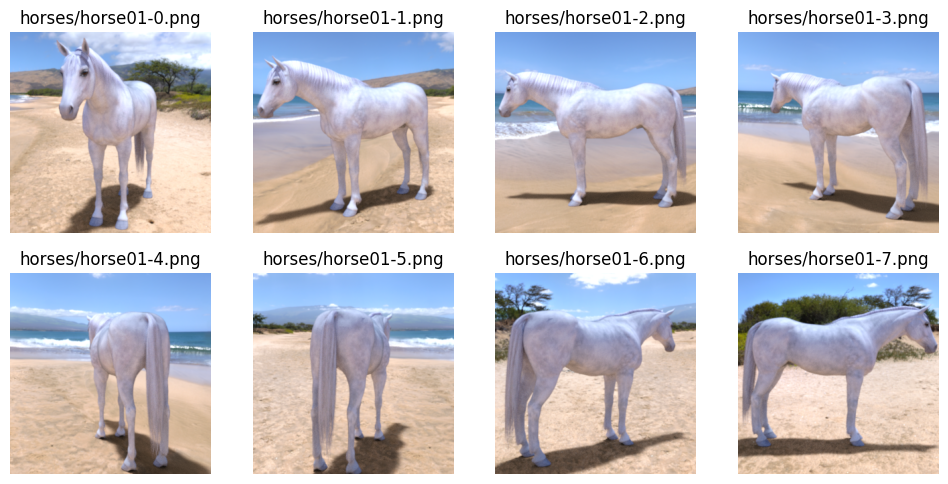

In [17]:
plt.figure(figsize=(12, 12))

for i, image_path in enumerate(training_generator_horses.filepaths[:8]):
    pic = plt.imread(image_path)
    image_name = training_generator_horses.filenames[i]
    plt.subplot(4, 4, i+1)
    plot_image(pic, image_name)

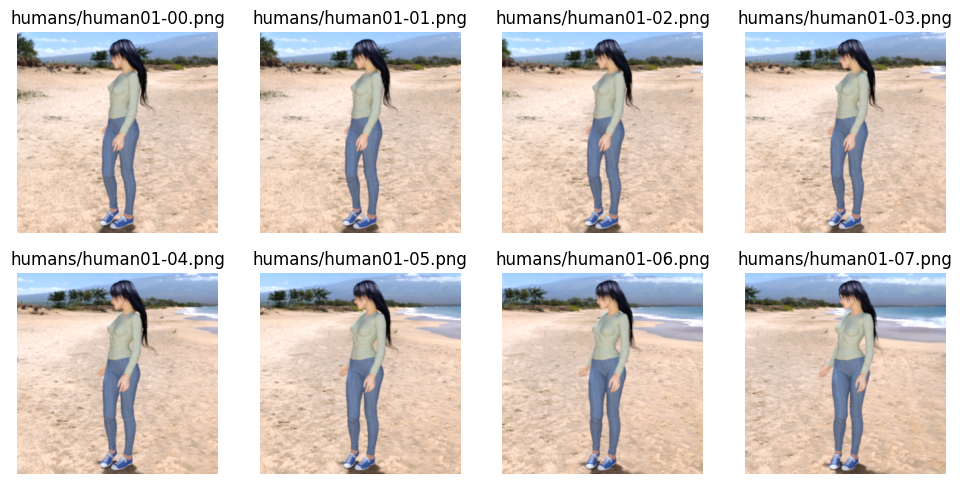

In [18]:
plt.figure(figsize=(12, 12))

for i, image_path in enumerate(training_generator_humans.filepaths[:8]):
    pic = plt.imread(image_path)
    image_name = training_generator_humans.filenames[i]
    plt.subplot(4, 4, i+1)
    plot_image(pic, image_name)

## CNN Architecture for Horses or Humans

There are several differences between this dataset and the Fashion MNIST one that you have to take into account when designing the architecture for classifying images:

- images are much larger, $300 \times 300$, so more layers may be needed
- images are full colour, so each image has 3 channels instead of one
- only two image types, so we have a binary classifier that can be implemented with just a single output neuron

## The Model

In [19]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Input(shape=(300, 300, 3)),

    # 3 * 3 * 3 * 16 * 16 = 448 param
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),

    # 0 param
    tf.keras.layers.MaxPooling2D(2, 2),

    # 3 * 3 * 32 * 16 + 32 = 4640 param
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),

    # 0 param
    tf.keras.layers.MaxPooling2D(2, 2),

    # 3 * 3 * 64 * 32 + 64 = 18496 params
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # 0 param
    tf.keras.layers.MaxPooling2D(2, 2),

    # 3 * 3 * 64 * 64 + 64 = 36928 params
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # 0 param
    tf.keras.layers.MaxPooling2D(2, 2),

    # 3 * 3 * 64 * 64 + 64 = 36928 params
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # 0 param
    tf.keras.layers.MaxPooling2D(2, 2),

    # 0 param
    tf.keras.layers.Flatten(),

    # 512 * 3136 + 512 = 1606144 param
    tf.keras.layers.Dense(512, activation='relu'),

    # 1 * 512 + 1 = 513 param
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

- Things to note about this code
 - First Layer:
   - we are definining 16 filters of size $3 \times 3$
   - the input shape is $(300, 300, 3)$
     - images have size $300 \times 300$ plus 3 colour channels
 - Output Layer:
   - a single nueron for a binary classifier that is activated by the `sigmoid` function
 - Stacked several convolutional layers
    - image source is quite large
    - we want, over time, to have many smaller images, each with features highlighted
    - after all the convolutional and pooling layers, it ends up with items of shape $7 \times 7$
      - these 49 pixels are ready to be flattened and passed to the dense neural network for matching with appropriate labels
  - We end up with more than 1.7 million parameters
   - slower to train

## Compilation

- **loss function**: `binary_crossentropy` since there are only two classes
- **optimizer**: *root mean square propagation,* `RMSProp`
 - it takes a learning rate parameter than allows us to tweak the learning

In [20]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

## Train the Model

In [21]:
history = model.fit(training_generator, epochs=15)

Epoch 1/15
33/33 [==============================] - 14s 376ms/step - loss: 0.6834 - accuracy: 0.5696
Epoch 2/15
33/33 [==============================] - 13s 372ms/step - loss: 0.4292 - accuracy: 0.8413
Epoch 3/15
33/33 [==============================] - 13s 371ms/step - loss: 0.2817 - accuracy: 0.9085
Epoch 4/15
33/33 [==============================] - 12s 368ms/step - loss: 0.1479 - accuracy: 0.9455
Epoch 5/15
33/33 [==============================] - 13s 374ms/step - loss: 0.1071 - accuracy: 0.9688
Epoch 6/15
33/33 [==============================] - 12s 368ms/step - loss: 1.6880 - accuracy: 0.9562
Epoch 7/15
33/33 [==============================] - 13s 375ms/step - loss: 0.0267 - accuracy: 0.9912
Epoch 8/15
33/33 [==============================] - 13s 373ms/step - loss: 0.0199 - accuracy: 0.9942
Epoch 9/15
33/33 [==============================] - 13s 376ms/step - loss: 0.2156 - accuracy: 0.9708
Epoch 10/15
33/33 [==============================] - 12s 371ms/step - loss: 0.0064 - accura

- After just 15 epochs we are getting a very impressive accuracy on the training set
    - This is not an indication of performance on data that the network hasn't previously seen

## Adding Validation to the Horses or Humans Dataset

When a TensorFlow model is trained with .fit() a second time, does it forget all the learning it did the first time?

ChatGPT's response:

No, when a TensorFlow model is trained with .fit() a second time, it does not forget the learning from the first time. The model retains all of the learned weights from the first training session and continues training from where it left off. This is because the weights are not reset between training sessions unless you explicitly reinitialize or recompile the model.

Here’s what happens when you call .fit() multiple times:

1.	**Weight Retention:** The model keeps its weights from the previous training session and uses them as the starting point for the second (or any subsequent) call to .fit(). It continues adjusting the weights based on the new data and the loss function.
2.	**Learning Rate and Optimizer State:** If you’re using an optimizer like Adam or SGD with momentum, the internal state of the optimizer (such as momentum or learning rate adjustments) is also retained unless you recompile the model. The optimizer will continue to update the model’s weights based on the existing state, ensuring that training picks up where it left off.
3.	**Reset Only if Compiled Again:** If you recompile the model (model.compile()), the optimizer state and possibly other parameters will be reset, and the model will effectively start training from scratch (with random or default initial weights, depending on the compilation process).

In [22]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    training_generator,
    epochs=15,
    validation_data=validation_generator
)

Epoch 1/15
33/33 [==============================] - 15s 427ms/step - loss: 0.1098 - accuracy: 0.9825 - val_loss: 2.0309 - val_accuracy: 0.8398
Epoch 2/15
33/33 [==============================] - 14s 422ms/step - loss: 0.0452 - accuracy: 0.9864 - val_loss: 2.0436 - val_accuracy: 0.8633
Epoch 3/15
33/33 [==============================] - 14s 421ms/step - loss: 0.2849 - accuracy: 0.9815 - val_loss: 3.4241 - val_accuracy: 0.7812
Epoch 4/15
33/33 [==============================] - 14s 428ms/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 3.1577 - val_accuracy: 0.8594
Epoch 5/15
33/33 [==============================] - 14s 419ms/step - loss: 0.2977 - accuracy: 0.9727 - val_loss: 2.5477 - val_accuracy: 0.8398
Epoch 6/15
33/33 [==============================] - 14s 424ms/step - loss: 7.5182e-04 - accuracy: 1.0000 - val_loss: 2.4770 - val_accuracy: 0.8633
Epoch 7/15
33/33 [==============================] - 14s 421ms/step - loss: 1.1484e-04 - accuracy: 1.0000 - val_loss: 2.4982 - val_accuracy

- Still impressive accuracy on the training data
- Just over 83% on the validation set
    - Overfitting
- The performance isn't bad considering how few images it was trained on

## Test Horse or Human Images

In [24]:
# from google.colab import files
# from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for file_name in uploaded.keys():
    path = '/content/' + file_name
    img = image.load_img(path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    image_tensor = np.vstack([x])
    classes = model.predict(image_tensor)
    print(classes)
    print(classes[0])
    if classes[0] > 0.5:
        print(file_name, ' is a human')
    else:
        print(file_name, ' is a horse')

Saving carlos.jpg to carlos (8).jpg
1/1 [==============================] - 0s 128ms/step
[[5.4834824e-11]]
[5.4834824e-11]
carlos (8).jpg  is a horse


### Why use `np.vstack([x])`? (Answer from ChatGPT)

Why Use np.vstack([x]) in This Context?

1.	Batch Dimension:
 - In deep learning frameworks like Keras, input data is typically fed into a model in batches, where each batch is a collection of samples. The shape of the input data expected by the model is usually (batch_size, height, width, channels) for image data.
 - In your example, after x = np.expand_dims(x, axis=0), x already has the shape (1, 300, 300, 3), which is a batch of size 1. This is the correct shape for a single image batch.
2.	Ensuring Correct Input Format:
 - By using np.vstack([x]), the code ensures that x is explicitly treated as a batch of images (even if it’s just one image). It is a way to “safeguard” the input format for the model, confirming that the data is in a format the model expects.
 - If x is already shaped as (1, 300, 300, 3), then np.vstack([x]) returns the same shape (1, 300, 300, 3).
 - If the code were generalized to handle more cases (like if x was not already in the desired shape), np.vstack() could be more helpful in stacking multiple arrays correctly.
3.	Code Robustness:
 - Using np.vstack() can sometimes make the code more robust, particularly in more dynamic scenarios where the number of images or the input format might vary.

### Predict on the Validation Set (pretend this is a test set) and use this to test my own calcuation of accuracy

In [25]:
validation_generator2 = image_data_gen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    class_mode='binary',
    shuffle=False
)

Found 256 images belonging to 2 classes.


In [26]:
model.evaluate(validation_generator2)

8/8 [==============================] - 2s 179ms/step - loss: 2.7140 - accuracy: 0.8555


[2.7140438556671143, 0.85546875]

In [27]:
predictions = model.predict(validation_generator2).flatten()
predicted_classes = (predictions > 0.5).astype(int)
true_classes = validation_generator.labels

8/8 [==============================] - 2s 180ms/step


In [28]:
my_accuracy = (predicted_classes == true_classes).sum() / len(predicted_classes)
my_accuracy

0.85546875

## Image Augmentation

- As TensorFlow is loading your data, it can create additional new data by amending what it has using a number of **transforms**
    - Rotation
    - Shifting horizontally
    - Shifting vertically
    - Shearing
    - Zooming
    - Flipping
- We already saw `ImageGenerator` do a transform when it normalized images

```python
ImageDataGeneraor(rescale=1/255)
```

In [29]:
image_data_gen2 = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    # rotate each image randomly up to 40 degrees left or right
    rotation_range=40,
    # translating the image up to 20%
    width_shift_range=0.2,
    height_shift_range=0.2,
    # shearing image by up to 20%
    shear_range=0.2,
    # zooming by up to 20%
    zoom_range=0.2,
    # randomly flipping the image horizontally
    horizontal_flip=True,
    # fillingin any missing pixes after a move or shear with nearest neighbours
    fill_mode='nearest'
)

- Training will take longer now due to all the extra images
- Accuracy might not be as high since it is no longer overfitting to a largely uniform set of data

In [30]:
training_generator2 = image_data_gen2.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [31]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    training_generator2,
    epochs=15,
    validation_data=validation_generator
)

Epoch 1/15
33/33 [==============================] - 29s 833ms/step - loss: 0.4759 - accuracy: 0.7994 - val_loss: 2.0094 - val_accuracy: 0.6289
Epoch 2/15
33/33 [==============================] - 28s 843ms/step - loss: 0.3912 - accuracy: 0.8569 - val_loss: 1.3416 - val_accuracy: 0.6953
Epoch 3/15
33/33 [==============================] - 27s 819ms/step - loss: 0.3776 - accuracy: 0.8685 - val_loss: 2.1731 - val_accuracy: 0.7188
Epoch 4/15
33/33 [==============================] - 28s 835ms/step - loss: 0.2250 - accuracy: 0.9143 - val_loss: 0.7023 - val_accuracy: 0.8516
Epoch 5/15
33/33 [==============================] - 28s 840ms/step - loss: 0.2343 - accuracy: 0.9143 - val_loss: 2.6907 - val_accuracy: 0.7227
Epoch 6/15
33/33 [==============================] - 28s 828ms/step - loss: 0.2215 - accuracy: 0.9445 - val_loss: 3.1606 - val_accuracy: 0.7305
Epoch 7/15
33/33 [==============================] - 28s 836ms/step - loss: 0.1759 - accuracy: 0.9299 - val_loss: 0.2556 - val_accuracy: 0.8984

- With the augmentations, training accuracy went down and validation accuracy went up slightly.
- Could be underfitting
    - Try tweaking the augmentation transforms

In [32]:
# from google.colab import files
# from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for file_name in uploaded.keys():
    path = '/content/' + file_name
    img = image.load_img(path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.0

    image_tensor = np.vstack([x])
    classes = model.predict(image_tensor)
    print(classes)
    print(classes[0])
    if classes[0] > 0.5:
        print(file_name, ' is a human')
    else:
        print(file_name, ' is a horse')

Saving carlos.jpg to carlos (9).jpg
1/1 [==============================] - 0s 101ms/step
[[7.571426e-06]]
[7.571426e-06]
carlos (9).jpg  is a horse


## Transfer Learning